In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv("Pecan.txt", delimiter="\t")

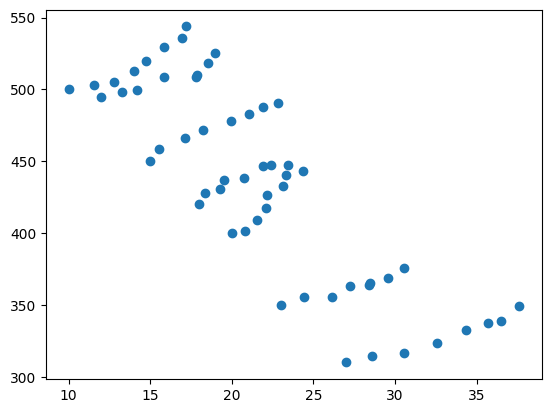

In [3]:
plt.scatter(df['Salinity level'], df['Pecan Yield'])

In [4]:
# Remove the Row ID column
data = df.drop(columns=['Row ID'])

In [5]:
# Define input (features) and output (target)
X = data.drop(columns=['Pecan Yield']).values
y = data['Pecan Yield'].values

In [6]:
# pip install torch scikit-learn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

In [7]:
# Split the data into training and test sets (80/20 split)
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.2, random_state=42)
#  Specifies the proportion of the dataset that 
# should be allocated to the test set. 
# Here, 0.2 means 20% of the data will be used
# for testing, and the remaining 80% will be 
# used for training.

In [8]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# StandardScaler: This is a class from 
# Scikit-learn used to standardize 
# features by removing the mean and 
# scaling to unit variance.
# Standardization: This process involves
# rescaling the features so that they have 
# a mean of 0 and a standard deviation of 1.
# This is important for many machine learning
# algorithms that perform better when 
# features are on a similar scale.

# This process is crucial for ensuring 
# that the model performs consistently,
# as many machine learning algorithms 
# assume or perform better when the 
# input features are on a similar scale.


In [9]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(
    X_train, dtype=torch.float32)

# torch.tensor(X_train): Converts 
# the X_train data (which is likely 
# a NumPy array or a Pandas 
# DataFrame) into a PyTorch tensor.
# dtype=torch.float32: Specifies that 
# the data type of the tensor should 
# be float32, which is a common 
# choice for numerical data in 
# deep learning models.
# Result: X_train_tensor is now a 
# PyTorch tensor containing the 
# standardized training input data, 
# ready for use in a neural network.

y_train_tensor = torch.tensor(
    y_train, dtype=torch.float32).view(-1, 1)

# torch.tensor(y_train): Converts the 
# y_train data (the target variable 
# for training) into a PyTorch tensor.
# .view(-1, 1): Reshapes the tensor 
# to have a shape of (-1, 1). 
# Here, -1 is a placeholder that tells 
# PyTorch to infer the correct size for 
# this dimension based on the other 
# dimensions. This ensures 
# that y_train_tensor has two dimensions, 
# with the second dimension being 1 
# (i.e., a column vector).
# Result: y_train_tensor is now a 2D 
# tensor with shape (n_samples, 1), 
# where n_samples is the number of 
# training samples.

X_test_tensor = torch.tensor(
    X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(
    y_test, dtype=torch.float32).view(-1, 1)

In [10]:
# Create DataLoader for batching
train_dataset = TensorDataset(
    X_train_tensor, y_train_tensor)
train_loader = DataLoader(
    train_dataset, batch_size=16, shuffle=True)

In [11]:
X_train.shape[1]

3

In [12]:
# Define the neural network model
#  defines a new class NeuralNetwork 
# that inherits from nn.Module. 
# By inheriting from nn.Module, 
# the NeuralNetwork class gains access 
# to all the functionalities provided 
# by PyTorch for building and managing neural networks.
class NeuralNetwork(nn.Module):
    def __init__(self): # Constructor
        # Start by calling the constructor of 
        # the parent class (nn.Module), ensuring 
        # that the class is properly initialized.
        super(NeuralNetwork, self).__init__()
        # nn.Linear creates a fully connected (linear) layer.
        self.fc1 = nn.Linear(X_train.shape[1], 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 1)

    # The forward method defines the forward pass of 
    # the network. It specifies how the input tensor
    # x should flow through the layers of the network.
    def forward(self, x):        
        x = self.fc1(x)
        x=F.leaky_relu(x, negative_slope=0.01)  # x=torch.relu(x)
        x = self.fc2(x)
        x=F.leaky_relu(x, negative_slope=0.01) # x=torch.relu(x)
        x = self.fc3(x)  # Output layer    
        return x

In [13]:
# Initialize the model, loss function, and optimizer
model = NeuralNetwork()
criterion = nn.L1Loss() # for mean absoluste loss
# criterion = nn.MSELoss()
optimizer = optim.Adam(
    model.parameters(), lr=0.01)

# optim.Adam: This creates an optimizer using the 
# Adam algorithm, which is a popular optimization
# algorithm that combines the advantages of two 
# other algorithms: AdaGrad and RMSProp. It adjusts
# the learning rate for each parameter individually
# based on estimates of lower-order moments.
# model.parameters(): This passes the model's
# parameters (weights and biases) to the optimizer.
# The optimizer will update these parameters during
# training based on the computed gradients.
# lr=0.01: This sets the learning rate, which 
# controls how much to adjust the model parameters
# with respect to the gradient. A learning rate of
# 0.01 is relatively standard, but it may need 
# tuning depending on the problem.


$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$\]


$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

In [14]:
# Training loop
epochs = 200
for epoch in range(epochs):
    # Set the model to training mode. This is 
    # important because certain layers, such 
    # as dropout or batch normalization, behave
    # differently during training than during 
    # evaluation. model.train() ensures that 
    # these layers are in training mode.
    model.train()
    total_loss = 0  # Initialize total loss for the epoch

    for batch_X, batch_y in train_loader:
        # Resets the gradients of all model parameters
        # to zero before starting the backpropagation
        # process for the current batch. This is 
        # important because gradients are accumulated
        # by default in PyTorch, so they need to be
        # cleared out before calculating the gradients
        # for the current batch.
        optimizer.zero_grad()
        predictions = model(batch_X)
        # Compute the loss between the model's 
        # predictions and the actual target values 
        # (batch_y).
        loss = criterion(predictions, batch_y)
        # Compute the gradients of the loss with 
        # respect to each model parameter using 
        # backpropagation. These gradients are 
        # used to update the model parameters 
        # in the next step.
        loss.backward()
        
        optimizer.step()

        total_loss += loss.item()  # Accumulate the loss for each batch

    average_loss = total_loss / len(train_loader)  # Compute the average loss for the epoch    
    print(f'Epoch {epoch+1}/{epochs}, Average Loss: {average_loss:.4f}')


Epoch 1/200, Average Loss: 438.1989
Epoch 2/200, Average Loss: 435.7981
Epoch 3/200, Average Loss: 435.2882
Epoch 4/200, Average Loss: 430.4089
Epoch 5/200, Average Loss: 424.3401
Epoch 6/200, Average Loss: 417.2837
Epoch 7/200, Average Loss: 409.5441
Epoch 8/200, Average Loss: 393.6500
Epoch 9/200, Average Loss: 374.9861
Epoch 10/200, Average Loss: 356.6382
Epoch 11/200, Average Loss: 332.1789
Epoch 12/200, Average Loss: 294.9758
Epoch 13/200, Average Loss: 253.1527
Epoch 14/200, Average Loss: 220.9356
Epoch 15/200, Average Loss: 190.2700
Epoch 16/200, Average Loss: 158.5062
Epoch 17/200, Average Loss: 121.5469
Epoch 18/200, Average Loss: 103.7166
Epoch 19/200, Average Loss: 105.3115
Epoch 20/200, Average Loss: 102.7310
Epoch 21/200, Average Loss: 94.9879
Epoch 22/200, Average Loss: 86.6960
Epoch 23/200, Average Loss: 75.0179
Epoch 24/200, Average Loss: 65.8227
Epoch 25/200, Average Loss: 62.1731
Epoch 26/200, Average Loss: 56.2441
Epoch 27/200, Average Loss: 45.3044
Epoch 28/200, Ave

In [15]:
# Evaluate the model on the test set
# Switch to Evaluation Mode. In this mode, 
# certain layers like dropout and batch normalization, 
# which behave differently during training, will 
# operate in evaluation mode, meaning they won't 
# apply dropout or update running statistics.
# Why Use eval()?: This ensures that the 
# model's behavior is consistent during 
# testing and that the evaluation reflects
# the true performance on unseen data.

model.eval()

# Disabling Gradient Calculation.
# The torch.no_grad() context manager 
# temporarily disables gradient computation. 
# Since gradients are only necessary during 
# training (when you need to update the 
# model's parameters), disabling them 
# during evaluation saves memory and 
# computational resources because
# pytorch will not track the operations
# for that it might need later for gradient
# computation.
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_loss = criterion(
        test_predictions, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 7.3876


In [16]:
[test_predictions, y_test_tensor]

[tensor([[439.6256],
         [508.6884],
         [328.9977],
         [494.3349],
         [483.5022],
         [475.4073],
         [438.1123],
         [533.4117],
         [326.2802],
         [371.2693],
         [357.7087],
         [429.1160]]),
 tensor([[430.4150],
         [500.0000],
         [316.7512],
         [490.2917],
         [487.6102],
         [477.7354],
         [420.0000],
         [535.8058],
         [314.3954],
         [365.5778],
         [350.0000],
         [426.8807]])]

In [17]:
# Print weights and biases for each layer in the model
def print_weights_and_biases(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Layer: {name}")
            print(f"Values:\n{param.data}\n")

In [18]:
# Call the function to print weights and biases
print_weights_and_biases(model)

Layer: fc1.weight
Values:
tensor([[-0.2838, -0.5385,  0.4280],
        [ 0.8322, -0.6214,  0.6849],
        [-0.4141,  0.9010, -0.7471],
        [ 0.9529, -1.0301,  0.7717],
        [ 0.7257, -0.2151,  0.8177],
        [-0.1737, -0.7952, -0.5588],
        [-0.6753,  0.3643, -0.2603],
        [-0.8063,  0.5553, -0.8816],
        [ 0.8918, -0.6487,  0.8875],
        [ 0.4598, -0.5047,  0.0798],
        [ 0.4995, -0.2721,  0.5186],
        [-0.5367,  0.1293, -0.1387],
        [ 0.2091,  0.6143, -0.6836],
        [-0.6738,  0.3797,  0.3034],
        [-0.0103, -0.3266, -0.2405],
        [ 0.0361,  0.0218,  0.3611],
        [-0.4846,  0.5205, -0.0505],
        [-0.1042,  0.5929, -0.2307],
        [ 0.4953,  0.2424, -0.1432],
        [ 0.8315, -0.4074,  0.5371],
        [-0.6415,  0.3578, -0.2271],
        [-0.6294,  0.1296,  0.0137],
        [-0.8083, -0.3085, -0.4704],
        [ 0.0119, -0.4073,  0.7258],
        [-0.3855,  0.0222,  0.2902],
        [-0.4356,  0.3317, -0.1935],
        [-0.

In [19]:
myData = [[90, 12, 52],
          [83, 15, 50],
          [100, 2, 90]]

myData_transformed = scaler.transform(myData)

myData_tensor= torch.tensor(
    myData_transformed, dtype=torch.float32)


In [20]:
model.eval()
with torch.no_grad():
    predictions = model(myData_tensor)


In [21]:
predictions

tensor([[493.8405],
        [470.1354],
        [769.3289]])

In [22]:
myData

[[90, 12, 52], [83, 15, 50], [100, 2, 90]]

In [23]:
myData_transformed

array([[ 0.53314162, -1.42914842,  0.42526729],
       [ 0.18871365, -0.98567586,  0.22595528],
       [ 1.02518157, -2.90739028,  4.21219547]])